In [ ]:
#Load the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
import pandas as pd

try:
    # Use 'r' before the string to make it a raw string
    train_df = pd.read_csv(r'D:\Network-Anomaly-DetectorV2\Dataset\raw\Training and Testing Sets\UNSW_NB15_training-set.csv', low_memory=False)
    test_df = pd.read_csv(r'D:\Network-Anomaly-DetectorV2\Dataset\raw\Training and Testing Sets\UNSW_NB15_testing-set.csv', low_memory=False)
    print("Data loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: File not found. Details: {e}")

Data loaded successfully!


In [23]:
# Combine for initial exploratory data analysis (EDA), but keep separate for model training later
df = pd.concat([train_df, test_df], ignore_index=True)

# Display initial information
print("\nCombined DataFrame Info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())
feature_names = df.columns.tolist()
# Display the result
print("\nFeature names stored successfully!")
print(f"Total number of features: {len(feature_names)}")
print("List of Feature Names:")
print(feature_names)



Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673

In [ ]:
#Initial Data Cleaning and Preparation

In [16]:
# Check for missing values
print("\nMissing values (counts):")
print(df.isnull().sum())

# --- CODE TO DROP ALL-ZERO COLUMNS ---

# Identify columns to check (usually numerical ones)
numerical_cols = df.select_dtypes(include=np.number).columns

columns_to_drop = []

print("\n--- Checking for All-Zero/Constant Columns ---")
for col in numerical_cols:
    # Check if the sum of the absolute values is 0 (meaning all entries are 0)
    # or if the column has only one unique value (i.e., it's constant)
    if (df[col].abs().sum() == 0) or (df[col].nunique() <= 1):
        # We check for unique <= 1 to catch columns that might be all NaN (after filling) or all a single value like 'A'
        # Since we're iterating over numerical columns, this primarily catches all-zero columns.
        columns_to_drop.append(col)
        print(f"Identified column to drop (All Zeros/Constant): {col}")

if columns_to_drop:
    df.drop(columns=columns_to_drop, inplace=True)
    print(f"\nDropped {len(columns_to_drop)} columns: {columns_to_drop}")
else:
    print("No numerical columns found to be all zero or constant.")



Missing values (counts):
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_c

In [17]:
# Insight: Many network features are categorical (object type) and might have 'nan' or ' ' (space) as missing data.
# 'service' and 'proto' are common culprits.
# Replace potential spaces or 'nan' strings with a proper NaN, then fill.

df = df.replace([' ', 'nan'], np.nan)
df['service'].fillna('none', inplace=True) # Traffic with no service like general network activity
df['proto'].fillna('other', inplace=True)  # Unknown or non-standard protocol

# After filling, check the data types again and convert if necessary.
# The 'attack_cat' (attack category) and 'label' (binary anomaly indicator) are crucial.

# Drop the 'id' column as it's an arbitrary index and doesn't contain useful information for analysis
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

C:\Users\Hello\AppData\Local\Temp\ipykernel_9736\705206533.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['service'].fillna('none', inplace=True) # Traffic with no service like general network activity
C:\Users\Hello\AppData\Local\Temp\ipykernel_9736\705206533.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are set

In [7]:
#Core Insights: Anomaly Distribution

In [18]:
# Check the class imbalance
anomaly_counts = df['label'].value_counts()
anomaly_percentage = df['label'].value_counts(normalize=True) * 100

print("\n--- Anomaly Class Distribution ---")
print(anomaly_counts)
print("\nPercentage Distribution:")
print(anomaly_percentage.round(2))



--- Anomaly Class Distribution ---
label
1    164673
0     93000
Name: count, dtype: int64

Percentage Distribution:
label
1    63.91
0    36.09
Name: proportion, dtype: float64


C:\Users\Hello\AppData\Local\Temp\ipykernel_9736\3413298327.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette=['skyblue', 'salmon'])


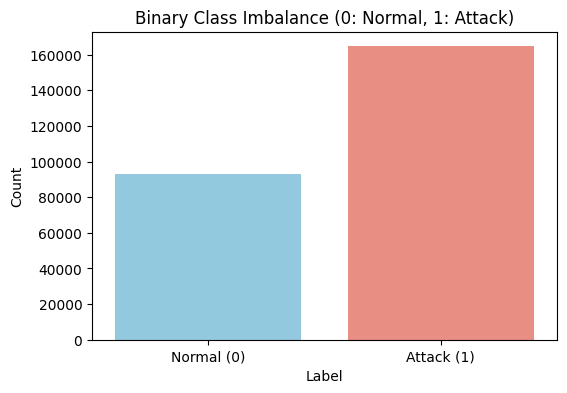

In [10]:
# Visualize the imbalance
plt.figure(figsize=(6, 4))
sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette=['skyblue', 'salmon'])
plt.title('Binary Class Imbalance (0: Normal, 1: Attack)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Normal (0)', 'Attack (1)'])
plt.show()

In [11]:
#Attack Category Distribution


--- Attack Category Distribution ---
attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64


C:\Users\Hello\AppData\Local\Temp\ipykernel_9736\968612439.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='attack_cat', data=attack_df, order=attack_df['attack_cat'].value_counts().index, palette='viridis')


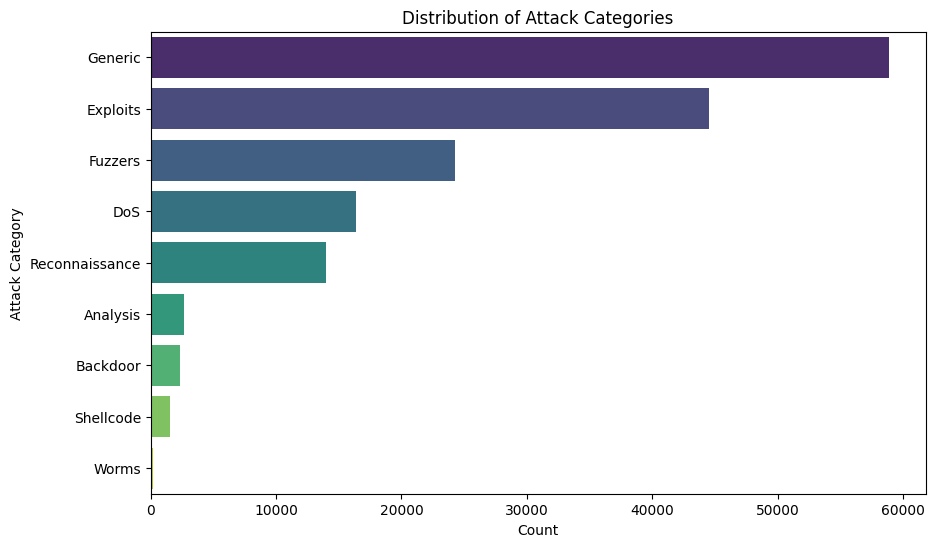

In [19]:
# Analyze the types of attacks
attack_cat_counts = df['attack_cat'].value_counts()

print("\n--- Attack Category Distribution ---")
print(attack_cat_counts)

# Visualize attack categories (excluding 'Normal')
attack_df = df[df['label'] == 1]
plt.figure(figsize=(10, 6))
sns.countplot(y='attack_cat', data=attack_df, order=attack_df['attack_cat'].value_counts().index, palette='viridis')
plt.title('Distribution of Attack Categories')
plt.xlabel('Count')
plt.ylabel('Attack Category')
plt.show()

In [ ]:
#Feature-Specific Insights


Top 10 Protocols in Attack Traffic:
proto
udp       70682
tcp       56072
unas      15599
ospf       3169
sctp       1474
any         396
gre         313
rsvp        264
ipv6        262
sun-nd      255
Name: count, dtype: int64

Top 10 Services in Attack Traffic:
service
-           77434
dns         58100
http        17650
smtp         4695
ftp          3004
ftp-data     1890
pop3         1524
dhcp          120
snmp          108
ssl            86
Name: count, dtype: int64


C:\Users\Hello\AppData\Local\Temp\ipykernel_9736\1256881096.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anomaly_proto.index, y=anomaly_proto.values, palette='Reds_d')


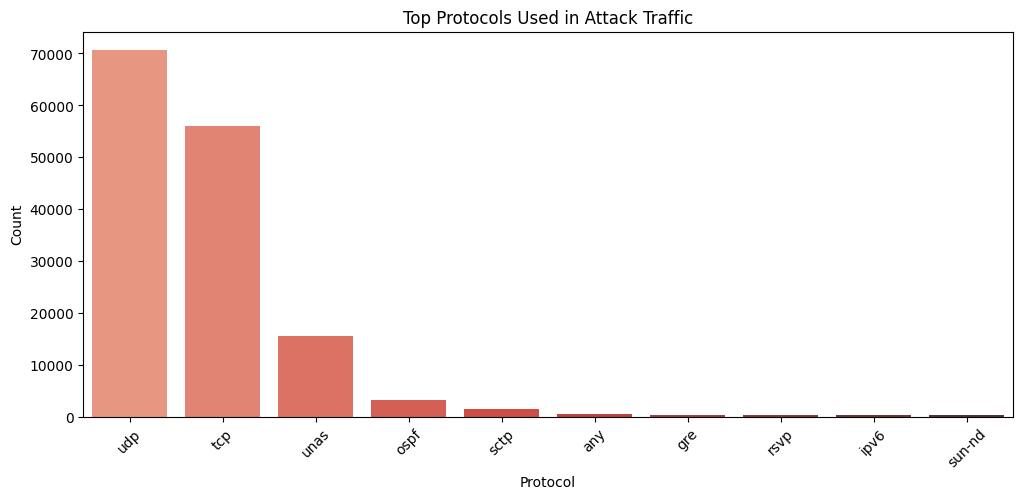

In [20]:
#Categorical Features: Service and Protocol
# Analyze the top 10 most common protocols for Anomalies (Label = 1)
anomaly_proto = df[df['label'] == 1]['proto'].value_counts().head(10)
print("\nTop 10 Protocols in Attack Traffic:")
print(anomaly_proto)

# Analyze the top 10 most common services for Anomalies (Label = 1)
anomaly_service = df[df['label'] == 1]['service'].value_counts().head(10)
print("\nTop 10 Services in Attack Traffic:")
print(anomaly_service)

# Visualization for protocols
plt.figure(figsize=(12, 5))
sns.barplot(x=anomaly_proto.index, y=anomaly_proto.values, palette='Reds_d')
plt.title('Top Protocols Used in Attack Traffic')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Plotting 39 numerical features.
Features: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']


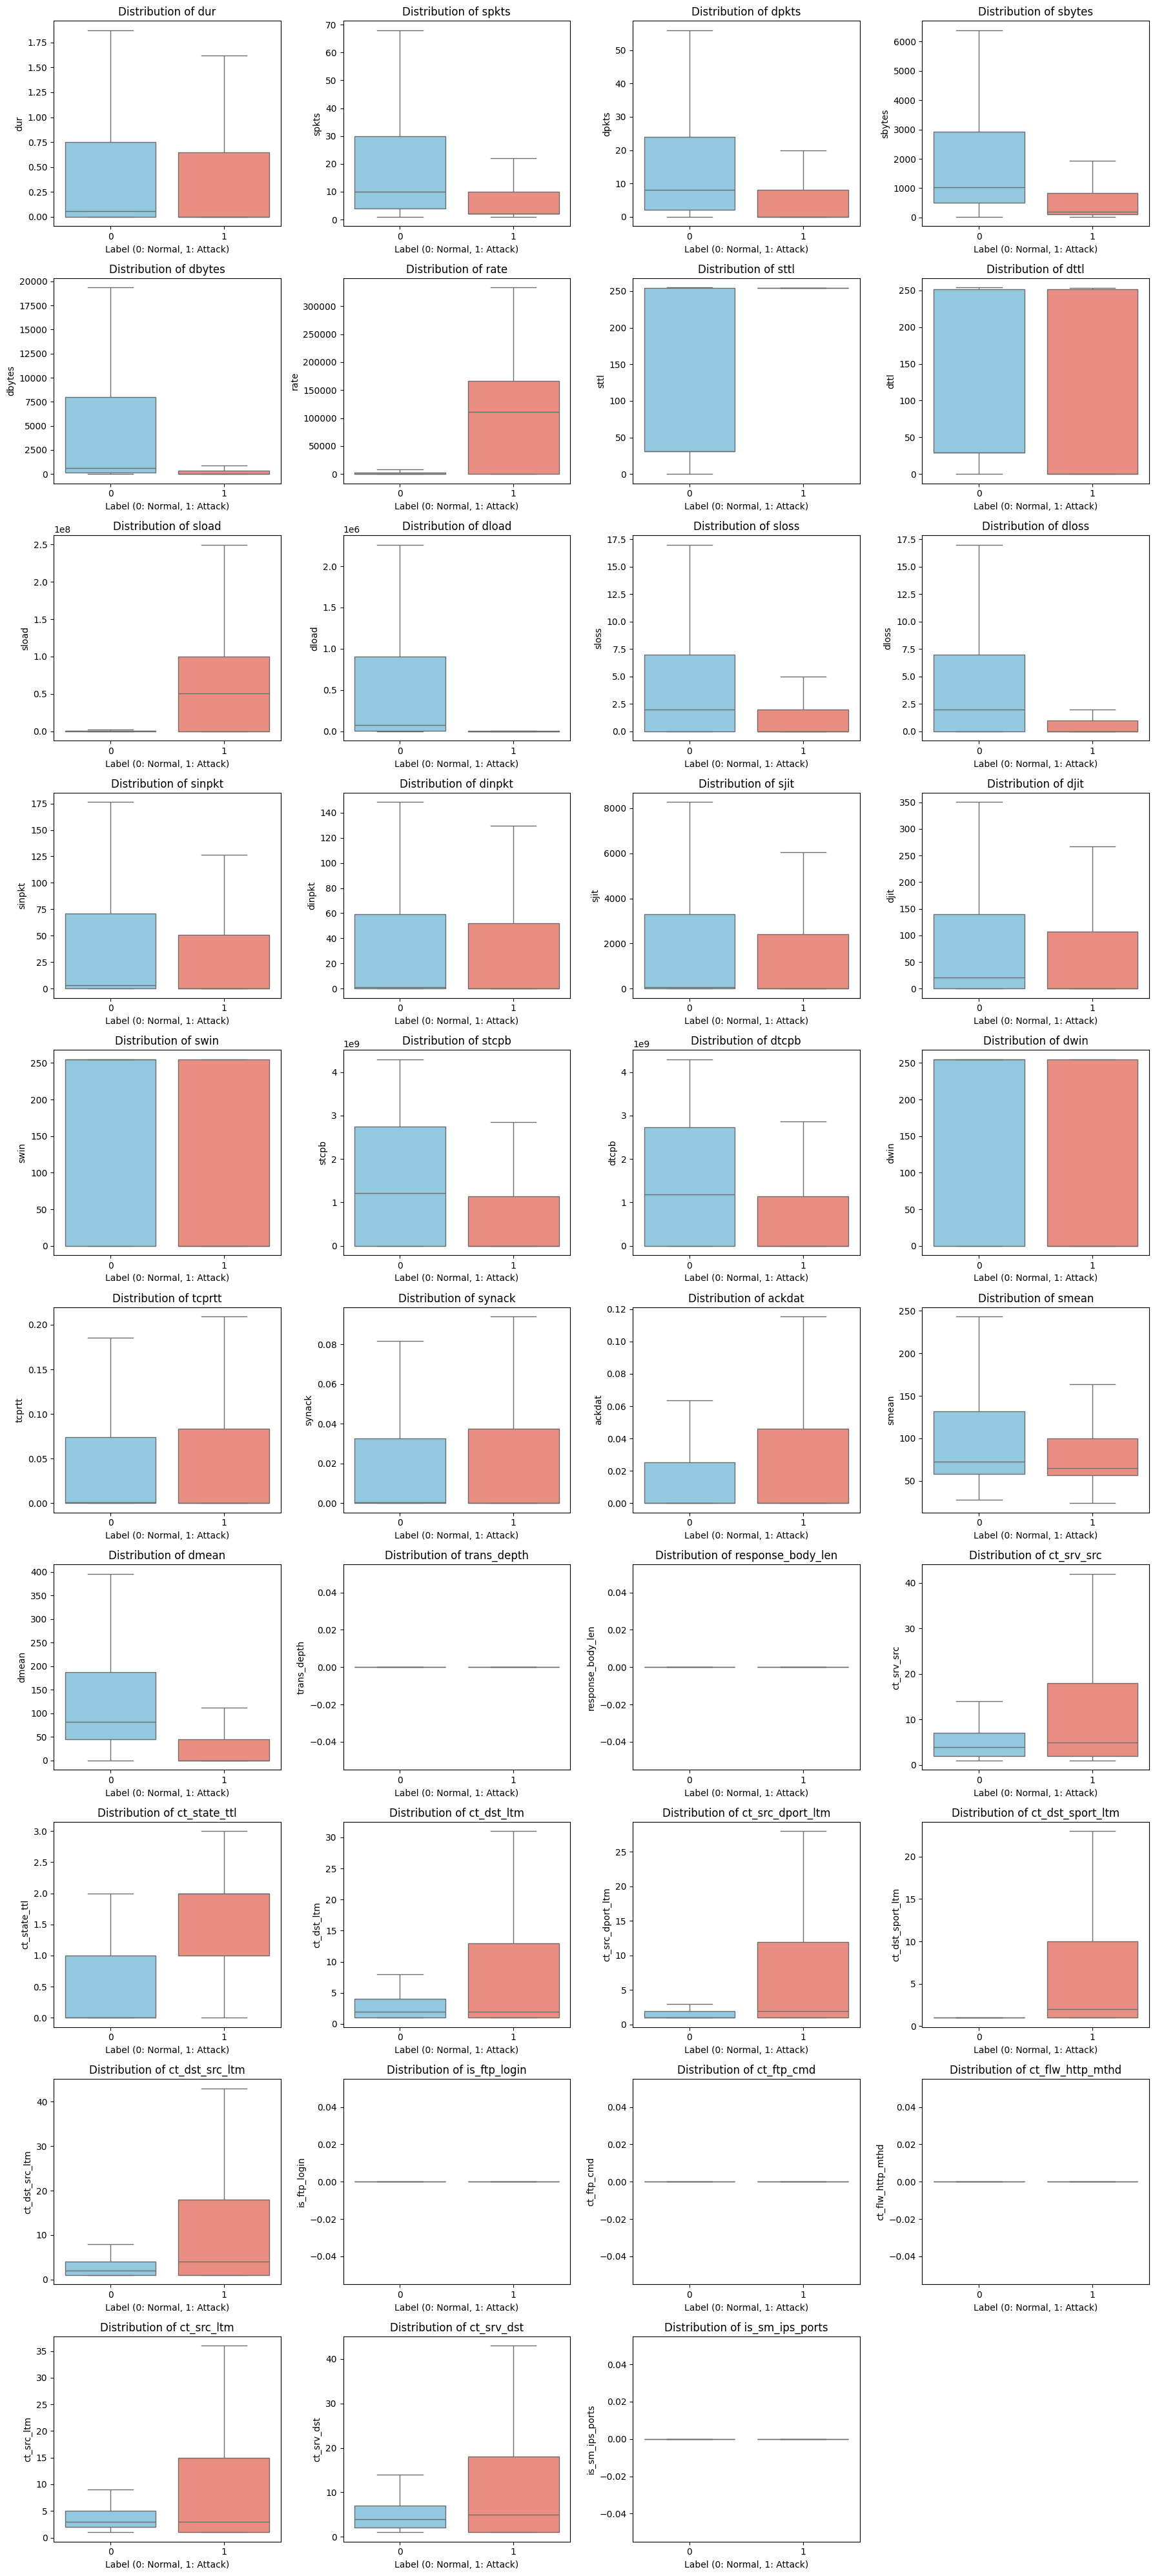

In [ ]:
# Identify numerical columns by checking the DataFrame's dtypes
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

# Exclude the target variable ('label') from the list of features to plot
numerical_features_to_plot = [
    col for col in numerical_features if col not in ['label', 'id']
]

print(f"Plotting {len(numerical_features_to_plot)} numerical features.")
print(f"Features: {numerical_features_to_plot}")

# --- 2. Iterate and Plot Boxplots ---

# Determine the layout for the subplots
# We'll use 4 columns, and calculate the necessary rows
n_features = len(numerical_features_to_plot)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols # Ceiling division

plt.figure(figsize=(18, 4 * n_rows)) # Adjust total figure size

for i, col in enumerate(numerical_features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Create the boxplot, comparing the numerical feature (y) against the binary label (x)
    sns.boxplot(
        x='label', 
        y=col, 
        data=df, 
        hue='label', 
        palette=['skyblue', 'salmon'],
        legend=False, 
        showfliers=False # Ignores extreme outliers for a clearer view of the central data
    )
    
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel('Label (0: Normal, 1: Attack)', fontsize=10)
    plt.ylabel(col, fontsize=10)

plt.tight_layout()
plt.show()


--- Correlation with Anomaly Label (Top/Bottom 10) ---
label               1.000000
sttl                0.624082
id                  0.490584
ct_state_ttl        0.476559
ct_dst_sport_ltm    0.371672
rate                0.335883
ct_src_dport_ltm    0.318518
ct_dst_src_ltm      0.299609
ct_src_ltm          0.252498
ct_srv_dst          0.247812
Name: label, dtype: float64
dloss             -0.075961
dpkts             -0.097394
sinpkt            -0.155454
is_sm_ips_ports   -0.160126
dtcpb             -0.263543
stcpb             -0.266585
dmean             -0.295173
dwin              -0.339166
dload             -0.352169
swin              -0.364877
Name: label, dtype: float64


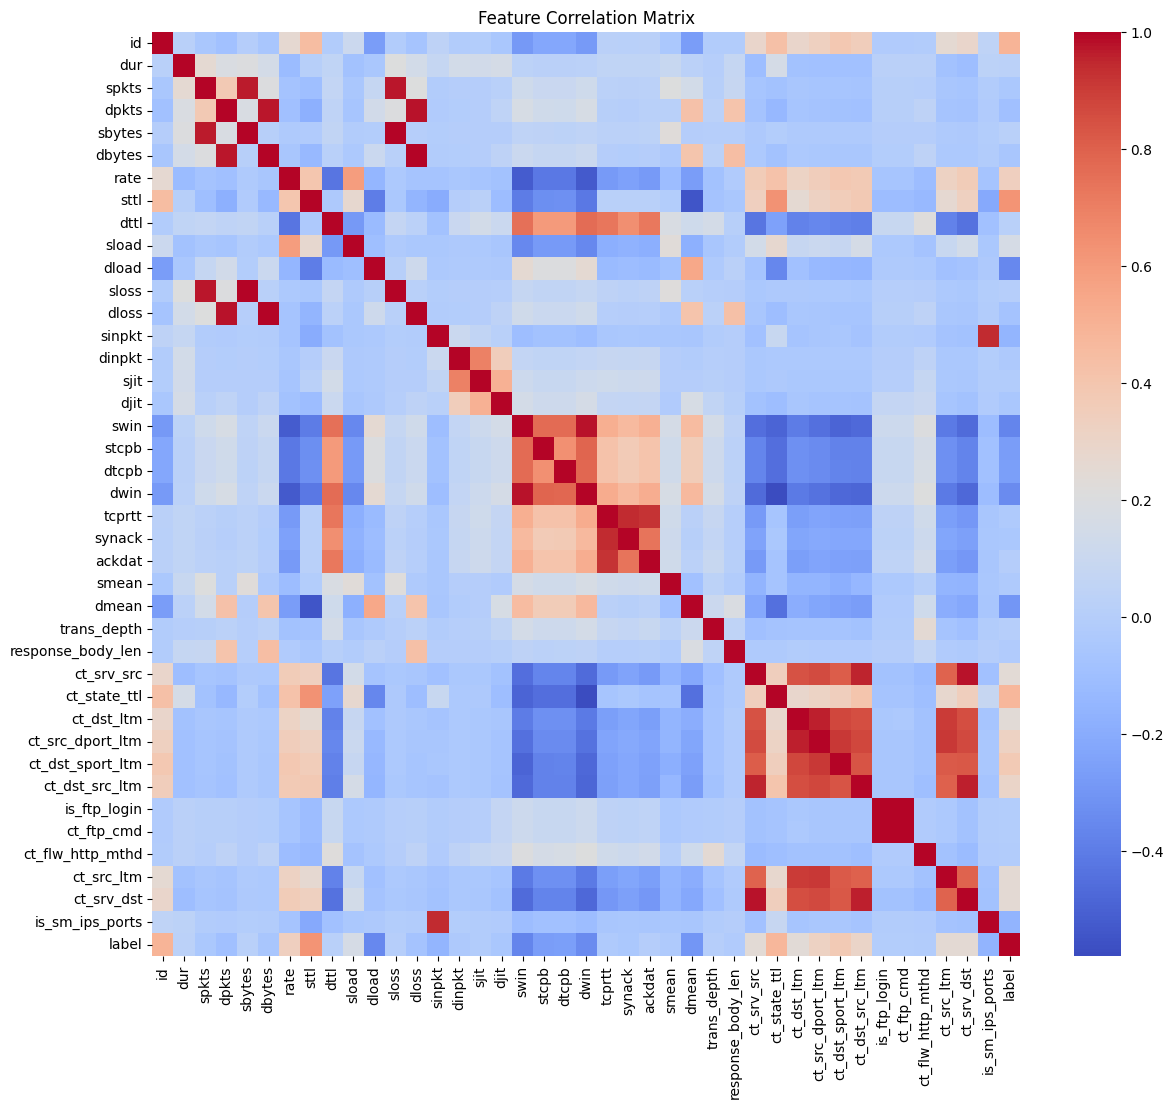

In [25]:
#correlation  analysis
# Encode categorical features before correlation analysis (simple one-hot or label encoding)
# For the purpose of quick correlation with 'label', let's use a subset of numericals.
correlation_matrix = df[numerical_features].corr()

# Correlation with the 'label'
label_corr = correlation_matrix['label'].sort_values(ascending=False)

print("\n--- Correlation with Anomaly Label (Top/Bottom 10) ---")
print(label_corr.head(10))
print(label_corr.tail(10))

# Visualize the full correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

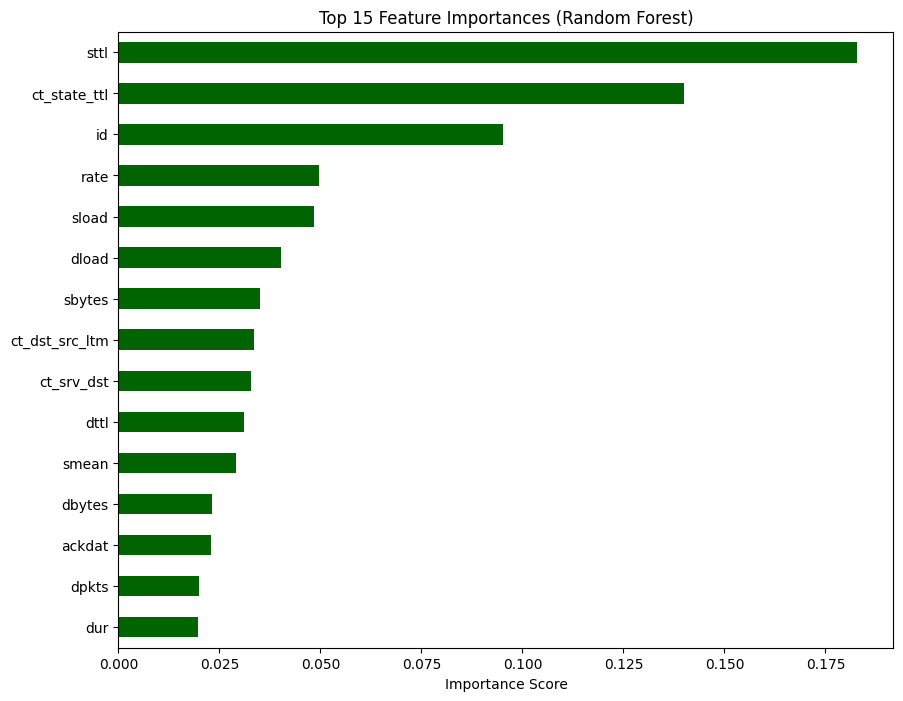

In [26]:

# Feature Importance (Pre-Modeling)
# Use a simple tree-based model (like Random Forest) to quickly assess which features contribute most to predicting the label before full-scale training. This provides a ranking of predictive power.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Prepare data (requires quick handling of categoricals for the RF model)
temp_df = df.copy()

# Label Encode categorical features for the model
for col in temp_df.select_dtypes(include='object').columns:
    temp_df[col] = LabelEncoder().fit_transform(temp_df[col].astype(str))

# Define X (features) and y (target)
X = temp_df.drop(columns=['label', 'attack_cat'], errors='ignore')
y = temp_df['label']

# 2. Train a simple Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
model.fit(X, y)

# 3. Extract and plot feature importance
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
importance.head(15).plot(kind='barh', color='darkgreen')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

# 🔥 Insight: This gives you the top N most predictive features (e.g., ct_state_ttl, rate, dload).
# This confirms which features you should focus on for cleaning, scaling, and engineering.


Top 10 Protocols by Anomaly Rate:
           count  sum  anomaly_rate
proto                              
3pc          132  132         100.0
a/n          132  132         100.0
aes-sp3-d    132  132         100.0
any          396  396         100.0
argus        131  131         100.0
aris         132  132         100.0
ax.25        132  132         100.0
bbn-rcc      132  132         100.0
bna          132  132         100.0
cbt          132  132         100.0


C:\Users\Hello\AppData\Local\Temp\ipykernel_9736\2105851424.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proto_analysis.head(10).index, y=proto_analysis.head(10)['anomaly_rate'], palette='Oranges_r')


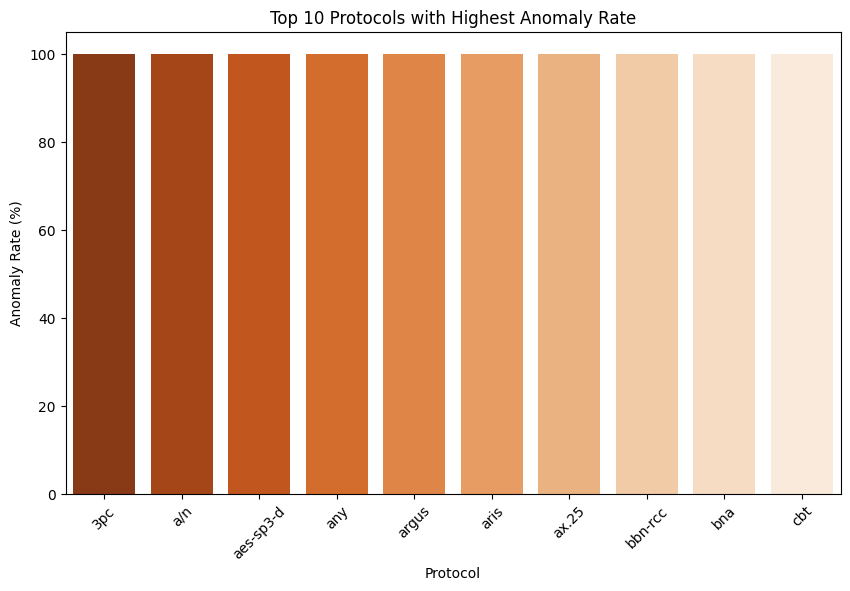

In [27]:
# Categorical Feature Analysis
# Go deeper than just counting categories; look at the anomaly rate within each category.

# a. Anomaly Rate by Protocol (proto)
# Calculate the percentage of traffic that is anomalous for each protocol.
# Calculate the proportion of attacks (label=1) for each protocol
proto_analysis = df.groupby('proto')['label'].agg(['count', 'sum'])
proto_analysis['anomaly_rate'] = (proto_analysis['sum'] / proto_analysis['count']) * 100
proto_analysis = proto_analysis.sort_values(by='anomaly_rate', ascending=False)

print("\nTop 10 Protocols by Anomaly Rate:")
print(proto_analysis.head(10).round(2))

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=proto_analysis.head(10).index, y=proto_analysis.head(10)['anomaly_rate'], palette='Oranges_r')
plt.title('Top 10 Protocols with Highest Anomaly Rate')
plt.ylabel('Anomaly Rate (%)')
plt.xlabel('Protocol')
plt.xticks(rotation=45)
plt.show()

# 🔥 Insight: If ICMP or specific tunneling protocols have a 100% anomaly rate, 
# they are strong indicators of attack traffic, likely scanning or probes.

In [ ]:
# b.Anomaly Rate by Service (service)
# Repeat the above analysis for the service feature.
service_analysis = df.groupby('service')['label'].agg(['count', 'sum'])
service_analysis['anomaly_rate'] = (service_analysis['sum'] / service_analysis['count']) * 100
service_analysis = service_analysis.sort_values(by='anomaly_rate', ascending=False)

print("\nTop 5 Services by Anomaly Rate:")
print(service_analysis[service_analysis['count'] > 1000].head(5).round(2)) # Filter for services with sufficient data
# 🔥 Insight: Services like 'ftp-data' or 'ssh' might show high anomaly rates if they are 
# targets for exploits or brute-forcing.


Top 5 Services by Anomaly Rate:
         count    sum  anomaly_rate
service                            
pop3      1528   1524         99.74
dns      68661  58100         84.62
smtp      6909   4695         67.95
http     27011  17650         65.34
ftp       4980   3004         60.32


In [29]:
# Look for features that are essentially flags or counters and see how they combine with other metrics.

# a. Flag Analysis (is_sm_ips_ports)
# The is_sm_ips_ports flag indicates if the source and destination IP/port are the same (often indicative of specific types of attacks like DoS).
# Analyze traffic where Source IP/Port == Dest IP/Port
sm_ips_ports_analysis = df.groupby('is_sm_ips_ports')['label'].agg(['count', 'sum'])
sm_ips_ports_analysis['anomaly_rate'] = (sm_ips_ports_analysis['sum'] / sm_ips_ports_analysis['count']) * 100

print("\nAnalysis of 'is_sm_ips_ports' Flag:")
print(sm_ips_ports_analysis.round(2))

# 🔥 Insight: If the anomaly rate is near 100% when this flag is 1, it's an extremely powerful feature.


Analysis of 'is_sm_ips_ports' Flag:
                  count     sum  anomaly_rate
is_sm_ips_ports                              
0                253995  164673         64.83
1                  3678       0          0.00


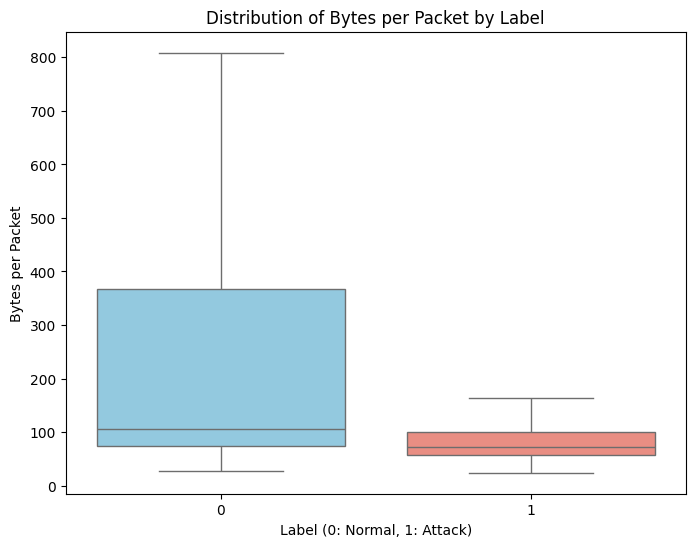

In [30]:
# b. Duration and Packet/Byte Ratio
# Create new, synthetic features that might better separate normal and attack traffic.
# Calculate Packets per Second (Rate) and Bytes per Packet
temp_df['pkt_rate'] = df['spkts'] / (df['dur'].replace(0, 1e-6)) # Avoid division by zero
temp_df['bytes_per_pkt'] = (df['sbytes'] + df['dbytes']) / (df['spkts'] + df['dpkts']).replace(0, 1)

# Plot the distribution of the engineered 'bytes_per_pkt'
plt.figure(figsize=(8, 6))
sns.boxplot(
    x='label', 
    y='bytes_per_pkt', 
    data=temp_df, 
    hue='label', 
    palette=['skyblue', 'salmon'], 
    legend=False, 
    showfliers=False
)
plt.title('Distribution of Bytes per Packet by Label')
plt.xlabel('Label (0: Normal, 1: Attack)')
plt.ylabel('Bytes per Packet')
plt.show()

# 🔥 Insight: Small packets per connection often suggest probes or scans, while large bytes per packet might 
# indicate data exfiltration or bulk transfers. Engineered features often show better separation than raw features.